In [17]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import pickle

In [18]:
# Baca data CSV
df = pd.read_csv('C:\\Users\\danisa\\OneDrive\\ドキュメント\\learning\\smt 3\\Project AI\\Stunting_Dataset.csv')

In [19]:
df.isnull().sum()

Gender           0
Age              0
Birth Weight     0
Birth Length     0
Body Weight      0
Body Length      0
Breastfeeding    0
Stunting         0
dtype: int64

In [20]:
df.dtypes

Gender            object
Age                int64
Birth Weight     float64
Birth Length       int64
Body Weight      float64
Body Length      float64
Breastfeeding     object
Stunting          object
dtype: object

In [21]:
df.select_dtypes(exclude=['number'])

,Gender,Breastfeeding,Stunting
0,Male,No,No
1,Female,No,Yes
2,Male,No,Yes
3,Male,No,Yes
4,Male,No,Yes
...,...,...,...
9995,Male,No,Yes
9996,Female,No,No
9997,Male,No,No
9998,Male,No,Yes


In [22]:
# Encoding manual untuk kolom kategorikal
category_columns = ['Gender', 'Stunting']
encoding_maps = {}
for col in category_columns:
    unique_values = df[col].unique()
    encoding_map = {val: idx for idx, val in enumerate(unique_values)}
    encoding_maps[col] = encoding_map
    df[col] = df[col].map(encoding_map)

# Menghapus kolom yang tidak diperlukan
columns_to_drop = ['Breastfeeding']
df = df.drop(columns=columns_to_drop)

df

,Gender,Age,Birth Weight,Birth Length,Body Weight,Body Length,Stunting
0,0,17,3.0,49,10.0,72.2,0
1,1,11,2.9,49,2.9,65.0,1
2,0,16,2.9,49,8.5,72.2,1
3,0,31,2.8,49,6.4,63.0,1
4,0,15,3.1,49,10.5,49.0,1
...,...,...,...,...,...,...,...
9995,0,15,3.0,49,9.0,63.0,1
9996,1,12,2.8,48,7.7,63.0,0
9997,0,16,2.8,49,7.7,49.0,0
9998,0,14,2.8,49,10.0,69.0,1


In [23]:
# Menyimpan DataFrame ke file CSV baru
df.to_csv('Stunting_Cleaningdata.csv', index=False)  # File akan disimpan tanpa menyertakan index

print("File telah disimpan")

File telah disimpan


ALGORITMA

In [24]:
# 1. Membaca Data 
df = pd.read_csv('C:\\Users\\danisa\\OneDrive\\ドキュメント\\learning\\smt 3\\Project AI\\Stunting_Cleaningdata.csv')

df

,Gender,Age,Birth Weight,Birth Length,Body Weight,Body Length,Stunting
0,0,17,3.0,49,10.0,72.2,0
1,1,11,2.9,49,2.9,65.0,1
2,0,16,2.9,49,8.5,72.2,1
3,0,31,2.8,49,6.4,63.0,1
4,0,15,3.1,49,10.5,49.0,1
...,...,...,...,...,...,...,...
9995,0,15,3.0,49,9.0,63.0,1
9996,1,12,2.8,48,7.7,63.0,0
9997,0,16,2.8,49,7.7,49.0,0
9998,0,14,2.8,49,10.0,69.0,1


In [25]:
# 2. Implementasi SMOTE untuk Mengatasi Ketidakseimbangan Data
def smote(X, y, k=5):
    minority_class = min(set(y), key=list(y).count)
    majority_class = max(set(y), key=list(y).count)

    X_minority = X[y == minority_class]
    n_minority = len(X_minority)
    n_majority = len(y[y == majority_class])

    if n_minority >= n_majority:
        return X, y

    n_synthetic = n_majority - n_minority

    def find_neighbors(data, point, k):
        distances = np.sqrt(((data - point) ** 2).sum(axis=1))
        return np.argsort(distances)[:k]

    synthetic_samples = []
    for _ in range(n_synthetic):
        idx = np.random.randint(0, n_minority)
        neighbors = find_neighbors(X_minority, X_minority[idx], k)
        neighbor_idx = np.random.choice(neighbors)
        diff = X_minority[neighbor_idx] - X_minority[idx]
        synthetic_sample = X_minority[idx] + np.random.rand() * diff
        synthetic_samples.append(synthetic_sample)

    synthetic_samples = np.array(synthetic_samples)
    X_balanced = np.vstack((X, synthetic_samples))
    y_balanced = np.hstack((y, [minority_class] * n_synthetic))

    return X_balanced, y_balanced

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Menggunakan SMOTE untuk menyeimbangkan data
X_balanced, y_balanced = smote(X, y, k=5)

# Membagi Dataset
def train_test_split_manual(X, y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    split_idx = int(len(X) * (1 - test_size))
    train_indices, test_indices = indices[:split_idx], indices[split_idx:]

    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = train_test_split_manual(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [26]:
# 3. Membuat Random Forest Manual dengan History
class HistoryRandomForest:
    def __init__(self, max_depth, max_features, n_trees_initial):
        self.max_depth = max_depth
        self.max_features = max_features
        self.n_trees_initial = n_trees_initial
        self.trees = []

    def _create_tree(self, X, y):
        def create_decision_tree(X, y, max_depth, depth=0):
            if len(set(y)) == 1 or depth == max_depth:
                return Counter(y).most_common(1)[0][0]

            best_feature, best_threshold, best_gini = None, None, float('inf')
            for feature in range(X.shape[1]):
                thresholds = np.unique(X[:, feature])
                for threshold in thresholds:
                    left = y[X[:, feature] <= threshold]
                    right = y[X[:, feature] > threshold]
                    if len(left) == 0 or len(right) == 0:
                        continue

                    gini = (len(left) / len(y)) * (1 - sum((np.sum(left == c) / len(left)) ** 2 for c in set(left))) + \
                           (len(right) / len(y)) * (1 - sum((np.sum(right == c) / len(right)) ** 2 for c in set(right)))

                    if gini < best_gini:
                        best_gini, best_feature, best_threshold = gini, feature, threshold

            if best_feature is None:
                return Counter(y).most_common(1)[0][0]

            left_indices = X[:, best_feature] <= best_threshold
            right_indices = X[:, best_feature] > best_threshold

            left_tree = create_decision_tree(X[left_indices], y[left_indices], max_depth, depth + 1)
            right_tree = create_decision_tree(X[right_indices], y[right_indices], max_depth, depth + 1)

            return {'feature': best_feature, 'threshold': best_threshold, 'left': left_tree, 'right': right_tree}

        return create_decision_tree(X, y, self.max_depth)

    def fit(self, X, y):
        n_samples = X.shape[0]
        for _ in range(self.n_trees_initial):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]

            feature_indices = np.random.choice(X.shape[1], self.max_features, replace=False)
            X_sample_subset = X_sample[:, feature_indices]

            tree = self._create_tree(X_sample_subset, y_sample)
            self.trees.append((tree, feature_indices))

    def predict_tree(self, tree, x):
        if not isinstance(tree, dict):
            return tree
        if x[tree['feature']] <= tree['threshold']:
            return self.predict_tree(tree['left'], x)
        else:
            return self.predict_tree(tree['right'], x)

    def predict(self, X):
        predictions = []
        for tree, feature_indices in self.trees:
            predictions.append([self.predict_tree(tree, x[feature_indices]) for x in X])

        predictions = np.array(predictions).T
        return [Counter(row).most_common(1)[0][0] for row in predictions]

In [27]:
# 4. Melatih Model Random Forest
forest = HistoryRandomForest(max_depth=5, max_features=3, n_trees_initial=10)
forest.fit(X_train, y_train)

In [28]:
# 5. Simpan dan Muat Model
def save_model(model, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model berhasil disimpan di {filepath}")

def load_model(filepath):
    with open(filepath, 'rb') as file:
        model = pickle.load(file)
    print(f"Model berhasil dimuat dari {filepath}")
    return model

# Simpan model ke file
model_filepath = "history_random_forest.pkl"
save_model(forest, model_filepath)

# Muat model dari file
loaded_forest = load_model(model_filepath)

Model berhasil disimpan di history_random_forest.pkl
Model berhasil dimuat dari history_random_forest.pkl


In [29]:
# 6. Evaluasi Model
y_pred = loaded_forest.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Akurasi Model yang Dimuat:", accuracy)

Akurasi Model yang Dimuat: 0.8045254556882464


Confusion Matrix:
[[1157  460]
 [ 162 1403]]

Classification Report:
     Class    Precision       Recall     F1-Score    Support
         0         0.88         0.72         0.79       1617
         1         0.75         0.90         0.82       1565

    Accuracy: 0.80
 Macro Avg:
   Precision: 0.82, Recall: 0.81, F1-Score: 0.80
 Weighted Avg:
   Precision: 0.82, Recall: 0.80, F1-Score: 0.80


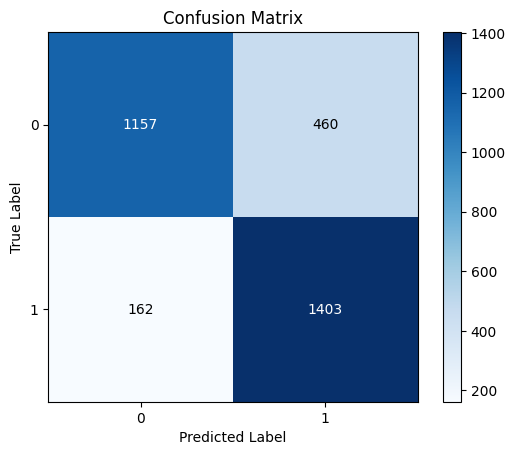

In [30]:
# 7. Evaluasi Model dengan Confusion Matrix dan Classification Report
def calculate_metrics(conf_matrix):
    """
    Menghitung precision, recall, f1-score, dan support berdasarkan confusion matrix.
    """
    precision = []
    recall = []
    f1_scores = []
    support = np.sum(conf_matrix, axis=1)

    for i in range(len(conf_matrix)):
        tp = conf_matrix[i, i]
        fp = np.sum(conf_matrix[:, i]) - tp
        fn = np.sum(conf_matrix[i, :]) - tp

        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

        precision.append(prec)
        recall.append(rec)
        f1_scores.append(f1)

    return precision, recall, f1_scores, support

# Confusion Matrix
n_classes = len(set(y))  # Jumlah kelas unik
conf_matrix = np.zeros((n_classes, n_classes), dtype=int)

for true, pred in zip(y_test, y_pred):
    conf_matrix[true, pred] += 1

# Hitung metrics
precision, recall, f1_scores, support = calculate_metrics(conf_matrix)

# Cetak Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

# Cetak Classification Report
print("\nClassification Report:")
header = f"{'Class':>10} {'Precision':>12} {'Recall':>12} {'F1-Score':>12} {'Support':>10}"
print(header)
print("=" * len(header))
for i in range(n_classes):
    print(f"{i:>10} {precision[i]:>12.2f} {recall[i]:>12.2f} {f1_scores[i]:>12.2f} {support[i]:>10}")

# Accuracy, Macro Avg, Weighted Avg
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

macro_avg = {
    "precision": np.mean(precision),
    "recall": np.mean(recall),
    "f1-score": np.mean(f1_scores)
}

weighted_avg = {
    "precision": np.sum([precision[i] * support[i] for i in range(n_classes)]) / np.sum(support),
    "recall": np.sum([recall[i] * support[i] for i in range(n_classes)]) / np.sum(support),
    "f1-score": np.sum([f1_scores[i] * support[i] for i in range(n_classes)]) / np.sum(support)
}

print("\n    Accuracy:", f"{accuracy:.2f}")
print(" Macro Avg:")
print(f"   Precision: {macro_avg['precision']:.2f}, Recall: {macro_avg['recall']:.2f}, F1-Score: {macro_avg['f1-score']:.2f}")
print(" Weighted Avg:")
print(f"   Precision: {weighted_avg['precision']:.2f}, Recall: {weighted_avg['recall']:.2f}, F1-Score: {weighted_avg['f1-score']:.2f}")

# Visualisasi Confusion Matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(n_classes), labels=[str(i) for i in range(n_classes)])
plt.yticks(np.arange(n_classes), labels=[str(i) for i in range(n_classes)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Tampilkan angka di dalam confusion matrix
thresh = conf_matrix.max() / 2
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.show()
